<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/Toy_Hierarchical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGA, PQN, PMGA, and EM to the toy hierarchical model in Example 1 of [Scalable particle-based alternatives to EM](https://juankuntz.github.io/publication/parem/) and reproduces Figures 1 and 2 therein. 

# Figure 1

To start, we load the modules we need and implement the algorithms. The algorithms take the following inputs:

*   y : D-dimensional vector of observations,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   th : 1-dimensional vector containing the initial parameter guess,
*   X : D x N matrix containing the initial particle cloud;

and return a single output:

*   th : K-dimensional vector of parameter estimates.

In [ ]:
#@title Load modules.
import numpy as np  # Numpy for computations.
import matplotlib.pyplot as plt  # Pyplot for plots.

In [ ]:
#@title Implement algorithms.


'-------------------------------- Algorithms ----------------------------------'


def PGA(y, h, K, N, th, X):
    D = y.size  # Extract dimension of latent variables.
    for k in range(K):
        'Update parameter estimate:'
        th = np.append(th, th[k] + h*D*(THETA(X) - th[k]))
        'Update particle cloud:'
        X = (X + h*(y + th[k] - 2*X)
               + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
    return th


def PQN(y, h, K, N, th, X):
    D = y.size  # Extract dimension of latent variables.
    for k in range(K):
        'Update parameter estimate:'
        th = np.append(th, th[k] + h*(THETA(X) - th[k]))
        'Update particle cloud:'
        X = (X + h*(y + th[k] - 2*X)
               + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
    return th


def PMGA(y, h, K, N, X):
    D = y.size  # Extract dimension of latent variables.
    th = np.array([THETA(X)])  # Compute initial parameter estimate. 
    for k in range(K):
        'Update particle cloud:'
        X = (X + h*(y + th[k] - 2*X)
               + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        th = np.append(th, THETA(X)) # Update parameter estimate.
    return th


def EM(y, K, th):
    for k in range(K):
        th = np.append(th, th[k]/2 + y.mean()/2)  # Update parameter estimate.
    return th


'----------------------------- Auxiliary function -----------------------------'


def THETA(X):
    return X.mean()  # Return optimal parameter for particle cloud X.

Next, we choose the model parameters and we generate synthetic data:

In [ ]:
D = 100  # Dimensionality of latent variables.
thdata = 1  # Parameter value used to generate the data.

'Generate the data:'
y = np.random.normal(0, 1, (D, 1)) + np.random.normal(thdata, 1, (D, 1))

## Figure 1a

We examine the impact that different step-sizes have on PGA's stability:

(0.0, 300.0)

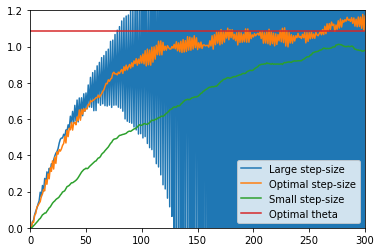

In [ ]:
'Set approximation parameters:'

K = 300  # Number of steps.
N = 10  # Number of particles.

th0 = np.array([0])  # Initial parameter guess.
X0 = np.zeros((D, N))  # Initial particle cloud.

'Run PGA using three different step-sizes:'

thL = PGA(y, 2.05/(2+D), K, N, th0, X0)  # Large step-size
thO = PGA(y, 2/(2+D), K, N, th0, X0)  # Optimal step-size 
thS = PGA(y, 0.75/(2+D), K, N, th0, X0)  # Small step-size

'Plot parameter estimates as a function of step number k:'

plt.plot(thL, label='Large step-size')
plt.plot(thO, label='Optimal step-size')
plt.plot(thS, label='Small step-size')
plt.plot(y.mean()*np.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.ylim([0, 1.2])
plt.xlim([0, K])

## Figure 1b,c

We compare the performance of PGA, PQN, PMGA, and EM:

(-3.0, 300.0)

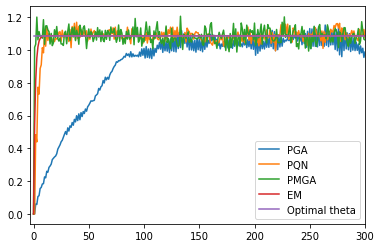

In [ ]:
'Run the algorithms using the optimal step-sizes:'

thPGA = PGA(y, 2/(2+D), K, N, th0, X0)
thPQN = PQN(y, 2/3, K, N, th0, X0)
thPMGA = PMGA(y, 1, K, N, X0)
thEM = EM(y, K, th0)

'Plot parameter estimates as a function of step number k:'

plt.plot(thPGA, label='PGA')
plt.plot(thPQN, label='PQN')
plt.plot(thPMGA, label='PMGA')
plt.plot(thEM, label='EM')
plt.plot(y.mean()*np.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.xlim([-K/100, K])

To extract converging estimates from PGA, PQN, and PMGA, we average over time (starting once the estimates reach stationarity). To this end, we use the following function that cumulatively averages all entries of a vector x past a threshold n: 

In [ ]:
#@title Cumulative mean.

def cmean(x, n):
    """
    Returns [x[0], ..., x[n-1], z[n], ..., z[K-1]], where N denotes x's size and 
    z[k] denotes the average of [x[n], ..., x[k]].
    """
    if n == 0:
      return np.cumsum(x[n:-1])/np.arange(1, x[n:-1].size + 1)
    else:
      return np.append(x[0:n-1],
                        np.cumsum(x[n:-1])/np.arange(1, x[n:-1].size + 1))

We then obtain the following:

(-3.0, 300.0)

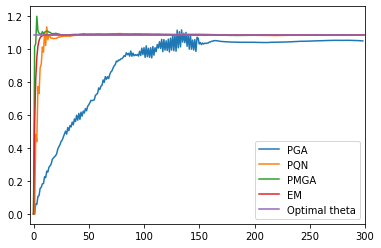

In [ ]:
plt.plot(cmean(thPGA, 150), label='PGA')
plt.plot(cmean(thPQN, 15), label='PQN')
plt.plot(cmean(thPMGA, 5), label='PMGA')
plt.plot(thEM, label='EM')
plt.plot(y.mean()*np.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.xlim([-K/100, K])

Lastly, we zoom in to the first 30 time-steps to differentiate between the PQN, PMGA, and EM estimates:

(-0.3, 30.0)

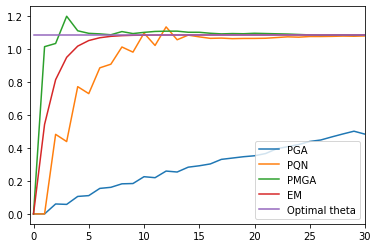

In [ ]:
plt.plot(cmean(thPGA, 150), label='PGA')
plt.plot(cmean(thPQN, 15), label='PQN')
plt.plot(cmean(thPMGA, 5), label='PMGA')
plt.plot(thEM, label='EM')
plt.plot(y.mean()*np.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.xlim([-0.3, 30])

# Figure 2


We investigate the asymptotic bias present in the variance of the posterior approximations produced by PMGA (time-averaged without burn-in). We focus on the uni-dimensional case (D=1) for which the bias is most pronounced. This requires generating new data:

In [ ]:
D = 1  # Dimensionality of latent variables.

'Generate the data:'
y = np.random.normal(0, 1, (D, 1)) + np.random.normal(thdata, 1, (D, 1))

Next, we tweak the PMGA code so that it returns (time-averaged without burn-in) variance estimates rather parameter estimates:

In [ ]:
#@title Tweaked PMGA
def PMGAv(y, h, K, N, X):
    D = y.size  # Extract dimension of latent variables.
    th = np.array([THETA(X)])  # Compute initial parameter estimate.

    '''Initialize the vectors that will contain the first two moments of the
    current particle cloud (required to compute the variance estimates):'''
    mu1 = np.reshape(X.mean(1), (D, 1))  # First moment.
    mu2 = np.reshape((X ** 2).mean(1), (D, 1)) # Second moment.

    for k in range(K):
        'Update particle cloud:'
        X = (X + h*(y + th[k] - 2*X)
               + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        th = np.append(th, THETA(X)) # Update parameter estimate.
        
        'Store moments:'
        mu1 = np.append(mu1, np.reshape(X.mean(1), (D, 1)), axis=1)
        mu2 = np.append(mu2, np.reshape((X ** 2).mean(1), (D, 1)), axis=1)

    'Compute time-averaged variance estimates as a function of k:'
    var = (np.cumsum(mu2)/np.arange(1, K + 2) 
           - (np.cumsum(mu1)/np.arange(1, K + 2)) ** 2)
    return var

## Figure 2a

In our first plot, we examine the dependence of the bias on the particle number. To this end, we fix a small step-size and large step number. In short, the larger the particle number, the smaller the bias:

(-200.0, 20000.0)

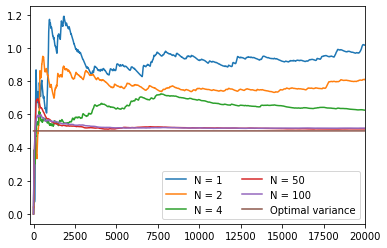

In [ ]:
K = 20000  # Number of steps.
h = 0.015  # Step-size.

'Compute variance estimates:'
var1 = PMGAv(y, h, K, 1, np.zeros((D, 1)))  # Using 1 particle.
var2 = PMGAv(y, h, K, 2, np.zeros((D, 2)))  # Using 2 particles.
var4 = PMGAv(y, h, K, 4, np.zeros((D, 4)))  # Using 4 particles.
var50 = PMGAv(y, h, K, 50, np.zeros((D, 50)))  # Using 50 particle.
var100 = PMGAv(y, h, K, 100, np.zeros((D, 100)))  # Using 100 particle.

'Plot estimates:'
plt.plot(var1, label='N = 1')
plt.plot(var2, label='N = 2')
plt.plot(var4, label='N = 4')
plt.plot(var50, label='N = 50')
plt.plot(var100, label='N = 100')
plt.plot(0.5*np.ones(K), label='Optimal variance')
plt.legend(loc='lower right', ncol=2)
plt.xlim([-K/100, K])

## Figure 2b

Next, we examine how the bias depends on the step-size. To do so, we fix large particle and step numbers. This time, the smaller the step-size, the smaller the bias:

(-200.0, 20000.0)

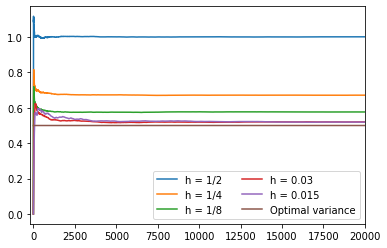

In [ ]:
N = 100  # Number of particles. 

X0 = np.zeros((D, N))  # Initial particle cloud (with amended dimension).

'Compute variance estimates:'
var05 = PMGAv(y, 1/2, K, N, X0)  # Using a step-size of 1/2.
var025 = PMGAv(y, 1/4, K, N, X0)  # Using a step-size of 1/4.
var0125 = PMGAv(y, 1/8, K, N, X0)  # Using a step-size of 1/8.
var003 = PMGAv(y, 0.03, K, N, X0)  # Using a step-size of 0.03.
var0015 = PMGAv(y, 0.015, K, N, X0)  # Using a step-size of 0.015.

'Plot estimates:'
plt.plot(var05, label='h = 1/2')
plt.plot(var025, label='h = 1/4')
plt.plot(var0125, label='h = 1/8')
plt.plot(var003, label='h = 0.03')
plt.plot(var0015, label='h = 0.015')
plt.plot(0.5*np.ones(K), label='Optimal variance')
plt.legend(loc='lower right', ncol=2)
plt.xlim([-K/100, K])

## Figure 2c

We can remove the bias stemming from the discretization of the time-axis by adding a population-wide accept-reject step. In other words, by running the following Metropolized version of PMGA:

In [ ]:
#@title Metropolized PMGA (Algorithm 1 in Appendix I).


'--------------------------------- Algorithm ----------------------------------'


def PMGAMH(y, h, K, N, X):
    D = y.size  # Extract dimension of latent variables.
    th = np.array([THETA(X)])  # Compute initial parameter estimate.

    '''Initialize vectors containing the first two moments of the current
    particle cloud (required to compute the variance estimates):'''
    mu1 = np.reshape(X.mean(1), (D, 1))  # First moment.
    mu2 = np.reshape((X ** 2).mean(1), (D, 1)) # Second moment.

    for k in range(K):
        'Propose a new particle cloud:'
        Z = (X + h*(y + THETA(X) - 2*X)
             + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        
        'Accept-reject step:'
        if np.random.uniform(0, 1, 1) < accept(X, Z, y, h, N):
            X = Z
        th = np.append(th, THETA(X)) # Update parameter estimate.

        'Store moments:'
        mu1 = np.append(mu1, np.reshape(X.mean(1), (D, 1)), axis=1)
        mu2 = np.append(mu2, np.reshape((X ** 2).mean(1), (D, 1)), axis=1)

    'Compute time-averaged variance estimates as a function of k:'
    var = (np.cumsum(mu2, axis=1)/np.arange(1, K + 2) 
           - (np.cumsum(mu1, axis=1)/np.arange(1, K + 2))**2)
    return var  # Returns the coordinate-wise variances as a function of k.


'----------------------------- Auxiliary function -----------------------------'


def accept(X, Z, y, h, N):
    'Compute acceptance probability for proposed moved X -> Z.'
    thx = THETA(X)
    thz = THETA(Z)
    s = 1
    for n in range(N):
        x = X[:, [n]]
        z = Z[:, [n]]
        tempx = ((y - x).T@(y - x)/2 + (x - thx).T@(x - thx)/2
                 + (z - x - h*(y + thx - 2*x)).T
                 @ (z - x - h*(y + thx - 2*x))/(4*h))
        tempz = ((y - z).T@(y - z)/2 + (z - thz).T@(z - thz)/2
                 + (x - z - h*(y + thz - 2*z)).T
                 @ (x - z - h*(y + thz - 2*z))/(4*h))
        s = s*np.exp(tempx - tempz)
    return np.minimum(1, s)

Regardless of the step-size h that we use, only bias stemming from the finite particle number N remains. However, for large particle numbers, we are forced to reduce the step-size to stop the acceptance probability from degenerating.

(0.0, 1.201627030229269)

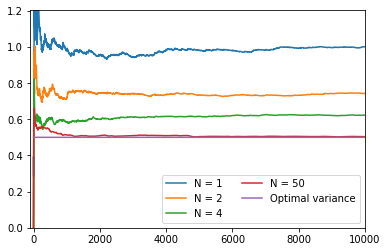

In [ ]:
K = 10000  # Number of steps.

'Compute estimates:'

var1 = PMGAMH(y, 1/2, K, 1, np.zeros((D, 1)))  # h = 1/2 and N = 1.
var2 = PMGAMH(y, 1/2, K, 2, np.zeros((D, 2)))  # h = 1/2 and N = 2.
var4 = PMGAMH(y, 1/2, K, 4, np.zeros((D, 4)))  # h = 1/2 and N = 4.
var50 = PMGAMH(y, 1/4, K, 50, np.zeros((D, 50)))  # h = 1/4 and N = 50.

'Plot estimates:'

plt.plot(var1[0, :], label='N = 1')
plt.plot(var2[0, :], label='N = 2')
plt.plot(var4[0, :], label='N = 4')
plt.plot(var50[0, :], label='N = 50')
plt.plot(0.5*np.ones(K), label='Optimal variance')
plt.legend(loc='lower right', ncol=2)
plt.xlim([-K/100, K])
plt.ylim([0, 1.2*var1[0, -1]])